In [5]:
# %%
import numpy as np
import sys
import os

In [6]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"spores\v14_back\scripts\run\tests\optimization"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [7]:
from pendulum_wrapper import OptimizationPendulum
from config.defaults import create_config
from tree_topology import create_tree_topology, calculate_grandchildren_positions, calculate_metrics
from visualization import visualize_complete_tree

print("✅ Все импорты успешны")

✅ Все импорты успешны


🌱 Создание топологии дерева из позиции [3.14159265 0.        ]
📊 Создана топология:
  🍄 Детей: 4
  👶 Внуков: 8
✅ Топология создана
🎯 Правильные dt:
  dt_base: 0.01
  dt детей: [0.01 0.01 0.01 0.01]
  dt внуков: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
🌱 Пересчет позиций внуков с правильной сортировкой
  🍄 Ребенок 0: forward_max, u=+2.0, dt=+0.010 → [3.14161765 0.00499791]
  🍄 Ребенок 1: backward_max, u=+2.0, dt=-0.010 → [ 3.14161766 -0.00500291]
  🍄 Ребенок 2: forward_min, u=-2.0, dt=+0.010 → [ 3.14156766 -0.00499791]
  🍄 Ребенок 3: backward_min, u=-2.0, dt=-0.010 → [3.14156764 0.00500291]

🔄 Дети после сортировки по углу:
  0: forward_min под углом -90.3°
  1: backward_max под углом -89.7°
  2: forward_max под углом 89.7°
  3: backward_min под углом 90.3°

👶 От родителя 0 (forward_min):
    🌱 0: u=+2.0, dt=+0.0010 (forward) → [ 3.14156291 -0.00449757]
    🌱 1: u=+2.0, dt=-0.0010 (backward) → [ 3.14157291 -0.00549832]

👶 От родителя 1 (backward_max):
    🌱 0: u=-2.0, dt=+0.001

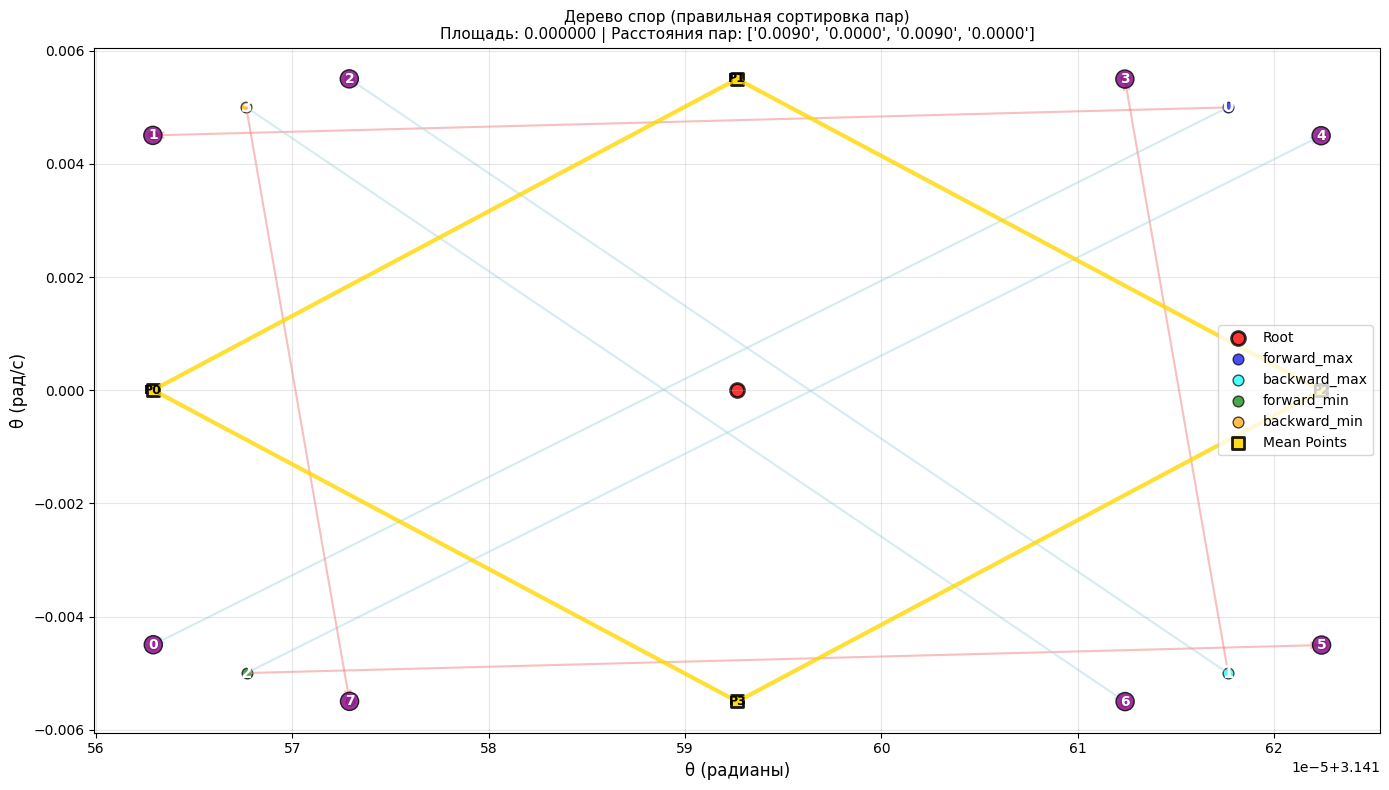


📊 РЕЗУЛЬТАТ:
  Площадь: 0.000000
  Расстояния пар: [9.00108871e-03 3.96983720e-05 9.00108871e-03 3.96983720e-05]


In [8]:
# %%
# Настройка
config = create_config()
config["debug"]["show_topology_creation"] = True
config["debug"]["show_calculations"] = True

pendulum = OptimizationPendulum(**config['pendulum'])
initial_pos = np.array([np.pi, 0.0])

# %%
# Создаем топологию
topology = create_tree_topology(initial_pos, pendulum, config)

# %%
# ПРАВИЛЬНЫЕ dt как вы просили:
dt_base = 0.01
# Дети: dt_base, Внуки: dt_base/10
correct_dt_vector = dt_base * np.hstack((np.ones(4), np.ones(8)/10))

print(f"🎯 Правильные dt:")
print(f"  dt_base: {dt_base}")
print(f"  dt детей: {correct_dt_vector[0:4]}")  
print(f"  dt внуков: {correct_dt_vector[4:12]}")

# Тестируем
grandchild_positions, metrics = visualize_complete_tree(topology, correct_dt_vector, pendulum, config)

print(f"\n📊 РЕЗУЛЬТАТ:")
print(f"  Площадь: {metrics['area']:.6f}")
print(f"  Расстояния пар: {metrics['pair_distances']}")